# Importing libraries

In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from scipy import sparse, signal, ndimage
from scipy.linalg import toeplitz, matmul_toeplitz, circulant
import multiprocessing

## The algorithm from the preprint with one Python for loop

In [2]:
def MyConv(X, K):
    """
    Intput:
    X - numpy.array, image
    K - numpy.array, kernel
    Output:
    2D convolution of X and K; type numpy.array
    """
    p, q = K.shape
    m, n = X.shape
    row = np.zeros(n-q+1)
    row[0] = K[0, 0]
    col = np.pad(K, ((0,0),(0,n-q)), mode="constant")
    col = col.reshape((-1,))
    A = toeplitz(col, row)
    B = np.empty((m-p+1, p*n))
    reshapedX = X.reshape((-1,))
    for k in range(m-p+1): 
        B[k] = reshapedX[k*n:(k+p)*n]
    return B@A

## The algorithm from the preprint, Toeplitz multiplication

In [3]:
def MyConvToep(X, K):
    """
    Intput:
    X - numpy.array, image
    K - numpy.array, kernel
    Output:
    2D convolution of X and K; type numpy.array
    """
    p, q = K.shape
    m, n = X.shape
    row = np.zeros(n-q+1)
    row[0] = K[0, 0]
    col = np.pad(K, ((0,0),(0,n-q)), mode="constant")
    col = col.reshape((-1,))
    B = np.empty((m-p+1, p*n))
    reshapedX = X.reshape((-1,))
    indx = np.arange(0, (m-p+1)*n, n).reshape(-1,1) + np.arange(n*p)
    for k in range(m-p+1): 
        B[k] = reshapedX[k*n:(k+p)*n]
    return matmul_toeplitz((row, col), B.transpose()).transpose()

## The algorithm from the preprint without any for loops

In [4]:
def MyConvNP(X, K):
    """
    Intput:
    X - numpy.array, image
    K - numpy.array, kernel
    Output:
    2D convolution of X and K; type numpy.array
    """
    p, q = K.shape
    m, n = X.shape
    row = np.zeros(n-q+1)
    row[0] = K[0, 0]
    col = np.pad(K, ((0,0),(0,n-q)), mode="constant")
    col = col.reshape((-1,))
    A = toeplitz(col, row)
    A = scipy.sparse.csr_matrix(A)
    #B = np.zeros((m-p+1, p*n))
    reshapedX = X.reshape((-1,))
    indx = np.arange(0, (m-p+1)*n, n).reshape(-1,1) + np.arange(n*p)
    B = reshapedX[indx]
    return B@A

## The algorithm from the preprint, Toeplitz multiplication, with numpy

In [5]:
def MyConvToepNP(X, K):
    """
    Intput:
    X - numpy.array, image
    K - numpy.array, kernel
    Output:
    2D convolution of X and K; type numpy.array
    """
    p, q = K.shape
    m, n = X.shape
    row = np.zeros(n-q+1)
    row[0] = K[0, 0]
    col = np.pad(K, ((0,0),(0,n-q)), mode="constant")
    col = col.reshape((-1,))
    reshapedX = X.reshape((-1,))
    indx = np.arange(0, (m-p+1)*n, n).reshape(-1,1) + np.arange(n*p)
    B = reshapedX[indx]
    return matmul_toeplitz((row, col), B.transpose()).transpose()

## The algorithm from the preprint, Toeplitz multiplication via FFT

In [70]:
def matmult_toeplitz(col, row, v):
    v_row, v_col = v.shape
    mm, nn = row.size, col.size
    M = nn + mm - 1
    hatv = np.pad(v, ((0, M-v_row),(0, 0))) # padding v with zeros
    vals = np.concatenate((row[1:], col))
    ind_c = np.arange(M-1, -1,-1) 
    c = vals[ind_c]
    FFTv = np.fft.fft(hatv, axis=0).transpose()
    Lambda = np.fft.fft(c)
    LamFv = np.multiply(FFTv, Lambda)
    result = np.fft.ifft(LamFv, axis=1)
    return np.real(result[:,nn-1:])

In [71]:
def MyConvFFT(X, K):
    """
    Intput:
    X - numpy.array, image
    K - numpy.array, kernel
    Output:
    2D convolution of X and K; type numpy.array
    """
    p, q = K.shape
    m, n = X.shape
    row = np.zeros(n-q+1)
    row[0] = K[0, 0]
    col = np.pad(K, ((0,0),(0,n-q)), mode="constant")
    col = col.reshape((-1,))
    reshapedX = X.reshape((-1,))
    indx = np.arange(0, (m-p+1)*n, n).reshape(-1,1) + np.arange(n*p)
    v = reshapedX[indx].transpose()
    result = matmult_toeplitz(col,row, v)
    return result

## Numpy Cov2d FFT

In [72]:
def centered(arr, newshape):
    # Return the center newshape portion of the array.
    newshape = np.asarray(newshape)
    currshape = np.array(arr.shape)
    startind = (currshape - newshape) // 2
    endind = startind + newshape
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

In [73]:
def covFFT(X, K):
    m, n = X.shape
    p, q = K.shape
    F1 = np.fft.fft2(X, s=(m+p-1, n+q-1))
    F2 = np.fft.fft2(np.flip(K), s=(m+p-1, n+q-1))
    return centered(np.fft.irfft2(F1*F2, s=(m+p-1, n+q-1)), n-q+1)

In [74]:
def covFFTSC(X, K):
    m, n = X.shape
    p, q = K.shape
    F1 = scipy.fft.fft2(X, s=(m+p-1, n+q-1))
    F2 = scipy.fft.fft2(np.flip(K), s=(m+p-1, n+q-1))
    return centered(np.fft.irfft2(F1*F2, s=(m+p-1, n+q-1)), n-q+1)

## Convolution from scipy that uses FFT

In [75]:
def scconv(x, y):
    """
    Intput:
    X - numpy.array, image
    K - numpy.array, kernel
    Output:
    2D convolution of X and K; type numpy.array
    """
    y_flipped = np.flip(y)
    return scipy.signal.fftconvolve(x, y_flipped, mode = 'valid')

## Testing Outputs

In [76]:
m, n = 7, 7
p, q = 3, 3
X = np.random.normal(size=(m, n))
K = np.random.normal(size=(p, q))

In [77]:
covFFT(X, K)

array([[-0.22968187,  0.50650468, -2.92082866,  1.52813819, -2.22562001],
       [ 4.04992057,  0.43421349,  5.06365301, -2.88521417,  1.94185252],
       [-2.05406092, -0.76514693, -3.07908129,  4.2299217 , -1.68062542],
       [ 3.04872762, -3.4424193 ,  1.07263242, -1.65936173, -0.08481776],
       [-0.14188731,  0.90294506, -0.77087148,  2.60111694, -0.10866171]])

In [78]:
MyConv(X, K)

array([[-0.22968187,  0.50650468, -2.92082866,  1.52813819, -2.22562001],
       [ 4.04992057,  0.43421349,  5.06365301, -2.88521417,  1.94185252],
       [-2.05406092, -0.76514693, -3.07908129,  4.2299217 , -1.68062542],
       [ 3.04872762, -3.4424193 ,  1.07263242, -1.65936173, -0.08481776],
       [-0.14188731,  0.90294506, -0.77087148,  2.60111694, -0.10866171]])

In [79]:
MyConvNP(X, K)

array([[-0.22968187,  0.50650468, -2.92082866,  1.52813819, -2.22562001],
       [ 4.04992057,  0.43421349,  5.06365301, -2.88521417,  1.94185252],
       [-2.05406092, -0.76514693, -3.07908129,  4.2299217 , -1.68062542],
       [ 3.04872762, -3.4424193 ,  1.07263242, -1.65936173, -0.08481776],
       [-0.14188731,  0.90294506, -0.77087148,  2.60111694, -0.10866171]])

In [80]:
MyConvToep(X, K)

array([[-0.22968187,  0.50650468, -2.92082866,  1.52813819, -2.22562001],
       [ 4.04992057,  0.43421349,  5.06365301, -2.88521417,  1.94185252],
       [-2.05406092, -0.76514693, -3.07908129,  4.2299217 , -1.68062542],
       [ 3.04872762, -3.4424193 ,  1.07263242, -1.65936173, -0.08481776],
       [-0.14188731,  0.90294506, -0.77087148,  2.60111694, -0.10866171]])

In [81]:
MyConvFFT(X, K)

array([[-0.22968187,  0.50650468, -2.92082866,  1.52813819, -2.22562001],
       [ 4.04992057,  0.43421349,  5.06365301, -2.88521417,  1.94185252],
       [-2.05406092, -0.76514693, -3.07908129,  4.2299217 , -1.68062542],
       [ 3.04872762, -3.4424193 ,  1.07263242, -1.65936173, -0.08481776],
       [-0.14188731,  0.90294506, -0.77087148,  2.60111694, -0.10866171]])

In [82]:
scconv(X, K)

array([[-0.22968187,  0.50650468, -2.92082866,  1.52813819, -2.22562001],
       [ 4.04992057,  0.43421349,  5.06365301, -2.88521417,  1.94185252],
       [-2.05406092, -0.76514693, -3.07908129,  4.2299217 , -1.68062542],
       [ 3.04872762, -3.4424193 ,  1.07263242, -1.65936173, -0.08481776],
       [-0.14188731,  0.90294506, -0.77087148,  2.60111694, -0.10866171]])

## Generating random images

In [83]:
image_size = 100 # image size, square image, 
kernel_size = 30 # kernel size
iterations = 500 # number of images
images = np.random.normal(size=(iterations, image_size, image_size))
kernels = np.random.normal(size=(iterations, kernel_size, kernel_size))
set_of_images = [(x, y) for x, y in zip(images, kernels)]

# Benchmark - measuring comp. times

### FFT scipy

In [84]:
starttime = timeit.default_timer()
for x in set_of_images: 
    scconv(*x)
print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 0.13792822195682675


In [85]:
starttime = timeit.default_timer()
for x in set_of_images: 
    covFFT(*x)
print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 0.5339659689925611


### My Conv

In [86]:
starttime = timeit.default_timer()
for x in set_of_images: 
    MyConv(*x)
print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 0.9830793360015377


In [87]:
starttime = timeit.default_timer()
for x in set_of_images: 
    MyConvFFT(*x)
print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 7.849515460024122


### My Conv with Toeplitz matmult

In [88]:
starttime = timeit.default_timer()
for x in set_of_images: 
    MyConvToep(*x)
print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 4.409686240949668


### My Conv with numpy

In [89]:
starttime = timeit.default_timer()
for x in set_of_images: 
    MyConvNP(*x)
print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 1.7175549020175822


### My Conv with numpy with Toeplitz matmult

In [90]:
starttime = timeit.default_timer()
for x in set_of_images: 
    MyConvToepNP(*x)
print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 4.501848021987826


## Long benchmark

In [91]:
def generate_times(
    convfun,
    trials=10):
    image_size = 100
    iter_size = 100
    time_overall = []
    for kernel_size in tqdm(range(1, image_size), desc="Kernel size"):
        images = np.random.uniform(0, 1, size=(trials, iter_size, image_size, image_size))
        kernels = np.random.normal(size=(trials, iter_size, kernel_size, kernel_size))
        for j in range(trials):
            time_diff_result = []
            set_of_images = []
            for k in range(iter_size):
                X = images[j][k]
                K = kernels[j][k]
                set_of_images.append([X, K])
            starttime = timeit.default_timer()
            for x in set_of_images: 
                convfun(*x)
            time_diff =  timeit.default_timer() - starttime
            time_diff_result.append(time_diff)
        time_overall.append(time_diff_result)
    return np.array(time_overall).mean(axis=1)

In [92]:
time_conv_FFT_np = generate_times(covFFT)

Kernel size: 100%|██████████████████████████████| 99/99 [02:47<00:00,  1.70s/it]


In [93]:
time_conv_sc = generate_times(scconv)

Kernel size: 100%|██████████████████████████████| 99/99 [00:48<00:00,  2.06it/s]


In [94]:
time_conv_myalg = generate_times(MyConv)

Kernel size: 100%|██████████████████████████████| 99/99 [01:41<00:00,  1.02s/it]


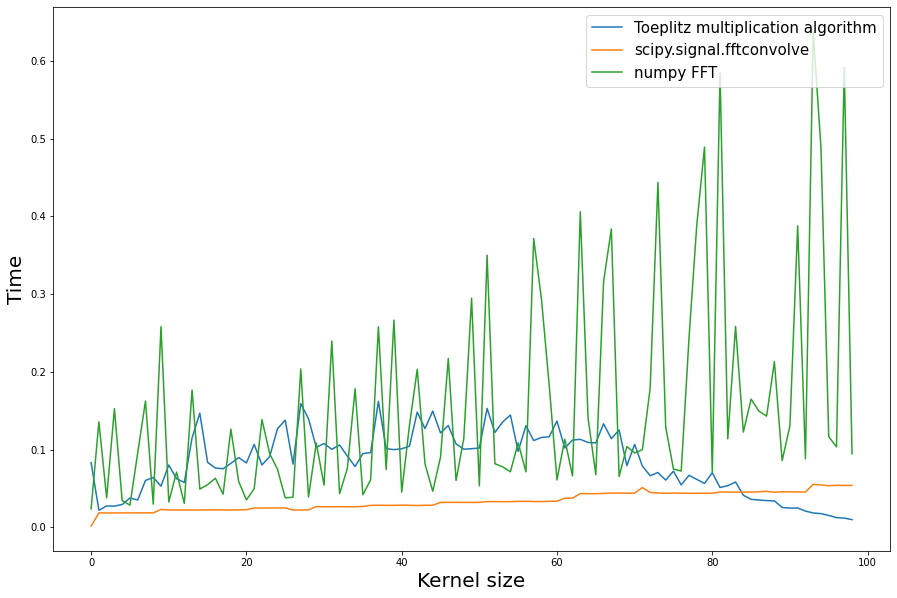

In [96]:
fig = plt.figure(figsize=(15,10))
plt.plot(time_conv_myalg, label="Toeplitz multiplication algorithm")
plt.plot(time_conv_sc, label="scipy.signal.fftconvolve")
plt.plot(time_conv_FFT_np, label="numpy FFT")
plt.plot()
plt.legend(loc="upper right", fontsize=15)
plt.xlabel("Kernel size", fontsize=20)
plt.ylabel("Time", fontsize=20)
fig.savefig("conv2d_cpu.png")
plt.show()

In [97]:
x = np.arange(10, 100, 5)
y1 = time_conv_FFT_np[x]
y2 = time_conv_myalg[x]
y3 = time_conv_sc[x]

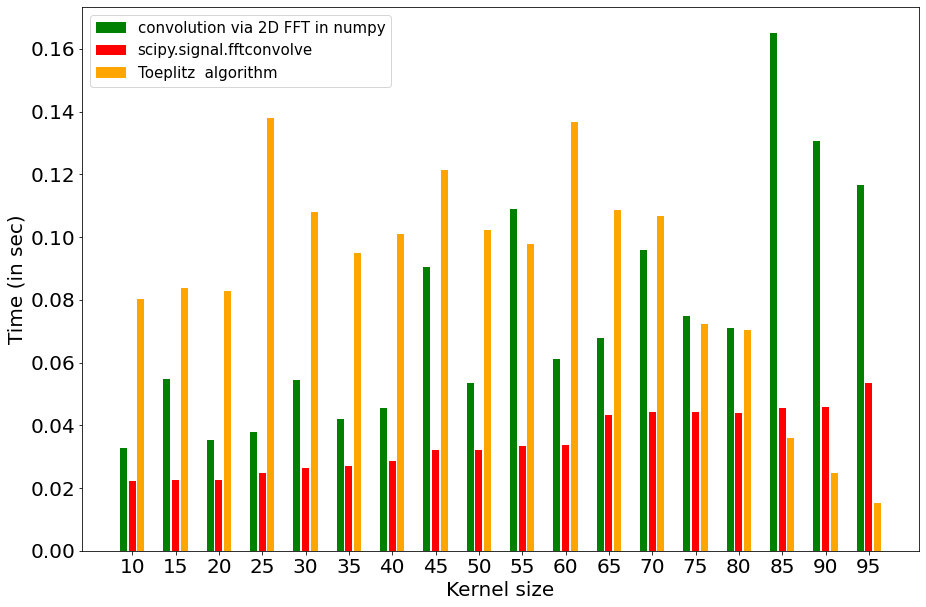

In [98]:
fig = plt.figure(figsize=(15, 10))
plt.bar(x-1, y1, color="green", label="convolution via 2D FFT in numpy")
plt.bar(x, y3, color="red", label="scipy.signal.fftconvolve")
plt.bar(x+1, y2, color="orange", label="Toeplitz  algorithm")
plt.legend(loc="upper left", fontsize=15)
plt.xlabel("Kernel size", fontsize=20)
plt.xticks(x, fontsize=20)
plt.ylabel("Time (in sec)", fontsize=20)
plt.yticks(fontsize=20)
fig.savefig("conv2d_cpu.jpg")
plt.show()